## Deep Learning
### Assignment 3
Previously in 2_fullyconnected.ipynb, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

Solution variant https://www.ritchieng.com/machine-learning/deep-learning/tensorflow/regularization/

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from IPython.display import display, Image

/jet/var/python/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in 1_notmnist.ipynb.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:

- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


### Problem 1
Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.


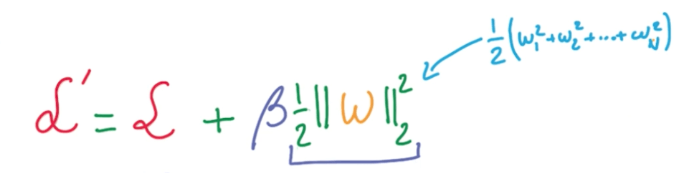

In [33]:
Image('3.PNG')

In [5]:
# Mini-batch gradient descent uses n data points (instead of 1 sample in SGD) at each iteration for loss/gradient

batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)

  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) + beta_regul*tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [7]:
# without regularization Test_accuracy = 86.0%, Val_acc = 78.7%, 

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.01}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 51.016102
Minibatch accuracy: 10.9%
Validation accuracy: 9.7%
Minibatch loss at step 500: 0.864583
Minibatch accuracy: 83.6%
Validation accuracy: 81.2%
Minibatch loss at step 1000: 0.685247
Minibatch accuracy: 81.2%
Validation accuracy: 81.4%
Minibatch loss at step 1500: 0.756896
Minibatch accuracy: 80.5%
Validation accuracy: 81.7%
Minibatch loss at step 2000: 0.829781
Minibatch accuracy: 82.0%
Validation accuracy: 81.5%
Minibatch loss at step 2500: 0.880346
Minibatch accuracy: 80.5%
Validation accuracy: 81.7%
Minibatch loss at step 3000: 0.908890
Minibatch accuracy: 77.3%
Validation accuracy: 81.3%
Test accuracy: 88.1%


In [10]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
    
    with tf.Session(graph=graph) as session:
        
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(num_steps):
            
            
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
              offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
              batch_data = train_dataset[offset:(offset + batch_size), :]
              batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
              feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
              _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


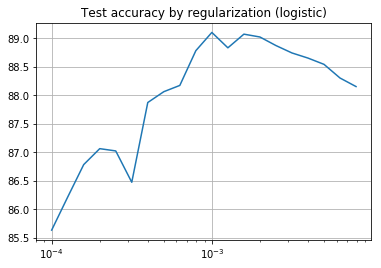

In [13]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

#### Regularize the NN with hidden layer with ReLu. Regularization should consider weights for both layers (Weights and Weights2)
### Test accuracy without reg = 86%    with reg = 90%
 

In [15]:
# Mini-batch gradient descent uses n data points (instead of 1 sample in SGD) at each iteration for loss/gradient


batch_size = 128

n_relu = 1024 # number of ReLu layers

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
    
  beta_regul = tf.placeholder(tf.float32)

  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, n_relu]))
  biases = tf.Variable(tf.zeros([n_relu]))

  weights2 = tf.Variable(
    tf.truncated_normal([n_relu, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  out1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)

  
  # Training computation.
  logits = tf.matmul(out1, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) + beta_regul*(tf.nn.l2_loss(weights2) +
      tf.nn.l2_loss(weights)))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
    #valid prediction
  out1_v = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
  valid_prediction = tf.nn.softmax(
    tf.matmul(out1_v, weights2) + biases2)

    #test prediction
  out1_t = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(out1_t, weights2) + biases2)

In [16]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.001}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 646.730347
Minibatch accuracy: 10.9%
Validation accuracy: 29.4%
Minibatch loss at step 500: 196.627930
Minibatch accuracy: 82.0%
Validation accuracy: 82.2%
Minibatch loss at step 1000: 113.678665
Minibatch accuracy: 85.9%
Validation accuracy: 82.9%
Minibatch loss at step 1500: 68.905502
Minibatch accuracy: 85.2%
Validation accuracy: 80.9%
Minibatch loss at step 2000: 41.634487
Minibatch accuracy: 81.2%
Validation accuracy: 85.3%
Minibatch loss at step 2500: 25.352583
Minibatch accuracy: 83.6%
Validation accuracy: 86.1%
Minibatch loss at step 3000: 15.639710
Minibatch accuracy: 82.0%
Validation accuracy: 87.5%
Test accuracy: 92.7%



### Problem 2
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?



In [59]:
# Mini-batch gradient descent uses n data points (instead of 1 sample in SGD) at each iteration for loss/gradient

batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [63]:
# 3 batch samples (do 3 offset variant only)

num_steps = 3001
batch_var = [0,batch_size,2*batch_size]
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = batch_var[step%3]
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 16.406975
Minibatch accuracy: 22.7%
Validation accuracy: 20.0%
Minibatch loss at step 500: 0.015376
Minibatch accuracy: 100.0%
Validation accuracy: 65.8%
Minibatch loss at step 1000: 0.008260
Minibatch accuracy: 100.0%
Validation accuracy: 66.8%
Minibatch loss at step 1500: 0.004546
Minibatch accuracy: 100.0%
Validation accuracy: 67.3%
Minibatch loss at step 2000: 0.003404
Minibatch accuracy: 100.0%
Validation accuracy: 67.7%
Minibatch loss at step 2500: 0.003241
Minibatch accuracy: 100.0%
Validation accuracy: 67.9%
Minibatch loss at step 3000: 0.002310
Minibatch accuracy: 100.0%
Validation accuracy: 68.1%
Test accuracy: 74.7%


### Problem 3
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

###  Dropout command just make some values as zero in the out
                import tensorflow as tf

                x = [1., 2., 1., 4., 1.]
                Compute dropout on our tensor.
                result = tf.nn.dropout(x, 0.75)
                session = tf.Session()
                print(session.run(result))

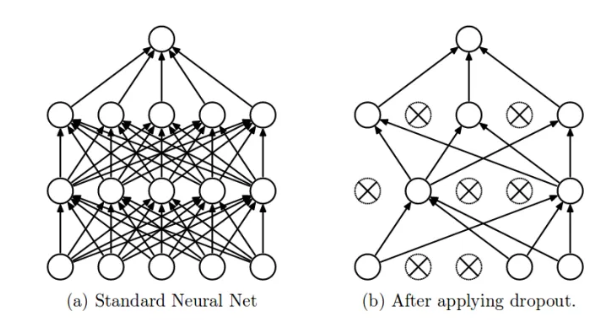

In [115]:
Image('4.PNG')

### For NN with ReLu and Hidden layer

In [85]:
# Mini-batch gradient descent uses n data points (instead of 1 sample in SGD) at each iteration for loss/gradient


batch_size = 128

n_relu = 1024 # number of ReLu layers


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
    
  keep_prob = tf.placeholder(tf.float32)

  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, n_relu]))
  biases = tf.Variable(tf.zeros([n_relu]))

  weights2 = tf.Variable(
    tf.truncated_normal([n_relu, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
    # out1 with dropout
  out1_full = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
  out1 = tf.nn.dropout(out1_full, keep_prob)
 

  # Training computation.
  logits = tf.matmul(out1, weights2) + biases2
  #logits = tf.nn.dropout(logits_full, keep_prob)
  
  loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  regularizers = tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights)
  loss = tf.reduce_mean(loss + 0.01*regularizers)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
    #valid prediction
  out1_v = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
  valid_prediction = tf.nn.softmax(
    tf.matmul(out1_v, weights2) + biases2)

    #test prediction
  out1_t = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(out1_t, weights2) + biases2)

In [86]:
# 3 batch samples (do 3 offset variant only)

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3667.627930
Minibatch accuracy: 9.4%
Validation accuracy: 26.0%
Minibatch loss at step 500: 21.363310
Minibatch accuracy: 84.4%
Validation accuracy: 84.7%
Minibatch loss at step 1000: 0.957911
Minibatch accuracy: 83.6%
Validation accuracy: 83.7%
Minibatch loss at step 1500: 0.832348
Minibatch accuracy: 81.2%
Validation accuracy: 83.8%
Minibatch loss at step 2000: 0.854988
Minibatch accuracy: 80.5%
Validation accuracy: 83.2%
Minibatch loss at step 2500: 0.898269
Minibatch accuracy: 79.7%
Validation accuracy: 83.4%
Minibatch loss at step 3000: 0.944876
Minibatch accuracy: 76.6%
Validation accuracy: 84.0%
Test accuracy: 89.8%


### Problem 4
Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

            global_step = tf.Variable(0)  # count the number of steps taken.
            learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
            
            
            Validation accuracy: 87.0%
            Test accuracy: 92.7%


In [32]:
# Mini-batch gradient descent uses n data points (instead of 1 sample in SGD) at each iteration for loss/gradient


batch_size = 128

n_relu1 = 1024 # number of ReLu layers
n_relu2 = int(n_relu1*0.5)
n_relu3 = int(n_relu2*0.5)
n_relu4 = int(n_relu3*0.5)
n_relu5 = int(n_relu4*0.5)

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
    
  keep_prob = tf.placeholder(tf.float32)
  beta_regul = tf.placeholder(tf.float32)

  # Variables.
    # Layer 1
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, n_relu1], stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases1 = tf.Variable(tf.zeros([n_relu1]))

    # Layer 2
  weights2 = tf.Variable(
    tf.truncated_normal([n_relu1, n_relu2], stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases2 = tf.Variable(tf.zeros([n_relu2]))
  
    # Layer 3
  weights3 = tf.Variable(
    tf.truncated_normal([n_relu2, n_relu3], stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases3 = tf.Variable(tf.zeros([n_relu3]))
    
    # Layer 4
  weights4 = tf.Variable(
    tf.truncated_normal([n_relu3, n_relu4], stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases4 = tf.Variable(tf.zeros([n_relu4]))
    
    # Layer 5
  weights5 = tf.Variable(
    tf.truncated_normal([n_relu4, n_relu5], stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases5 = tf.Variable(tf.zeros([n_relu5]))
    
  weights6 = tf.Variable(
    tf.truncated_normal([n_relu5, num_labels], stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases6 = tf.Variable(tf.zeros([num_labels]))

    # Training set
        # Output 1
  out1_full = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  out1 = tf.nn.dropout(out1_full, keep_prob)

        # Output 2
  out2_full = tf.nn.relu(tf.matmul(out1, weights2) + biases2)
  out2 = tf.nn.dropout(out2_full, keep_prob)

        # Output 3
  out3_full = tf.nn.relu(tf.matmul(out2, weights3) + biases3)
  out3 = tf.nn.dropout(out3_full, keep_prob)

        # Output 4
  out4_full = tf.nn.relu(tf.matmul(out3, weights4) + biases4)
  out4 = tf.nn.dropout(out4_full, keep_prob)

        # Output 5
  out5_full = tf.nn.relu(tf.matmul(out4, weights5) + biases5)
  out5 = tf.nn.dropout(out5_full, keep_prob)  
    
  logits = tf.matmul(out5, weights6) + biases6
    
  #logits = tf.nn.dropout(logits_full, keep_prob)
    
  
  loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  regularizers = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4) + tf.nn.l2_loss(weights5)+ tf.nn.l2_loss(weights6)
  
  loss = tf.reduce_mean(loss + beta_regul*regularizers)

  '''Optimizer'''
# Decaying learning rate
  global_step = tf.Variable(0)  # count the number of steps taken.
  start_learning_rate = 0.5
  learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    
    # Optimizer.
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
    # validation set prediction

        # Output 1
  out1_v = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        # Output 2
  out2_v = tf.nn.relu(tf.matmul(out1_v, weights2) + biases2)
        # Output 3
  out3_v = tf.nn.relu(tf.matmul(out2_v, weights3) + biases3)
        # Output 4
  out4_v = tf.nn.relu(tf.matmul(out3_v, weights4) + biases4)
        # Output 5
  out5_v = tf.nn.relu(tf.matmul(out4_v, weights5) + biases5)    

  logits_v = tf.matmul(out5_v, weights6) + biases6
  valid_prediction = tf.nn.softmax(logits_v)    

    #test prediction
  out1_t = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        # Output 2
  out2_t = tf.nn.relu(tf.matmul(out1_t, weights2) + biases2)
        # Output 3
  out3_t = tf.nn.relu(tf.matmul(out2_t, weights3) + biases3)
        # Output 4
  out4_t = tf.nn.relu(tf.matmul(out3_t, weights4) + biases4)
        # Output 5
  out5_t = tf.nn.relu(tf.matmul(out4_t, weights5) + biases5)    

  logits_t = tf.matmul(out5_t, weights6) + biases6
  test_prediction = tf.nn.softmax(logits_t) 

In [33]:
num_steps = 6001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 0.5, beta_regul : 0}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.306558
Minibatch accuracy: 8.6%
Validation accuracy: 9.6%
Minibatch loss at step 500: 0.860517
Minibatch accuracy: 78.9%
Validation accuracy: 82.8%
Minibatch loss at step 1000: 0.665203
Minibatch accuracy: 82.8%
Validation accuracy: 84.3%
Minibatch loss at step 1500: 0.640304
Minibatch accuracy: 81.2%
Validation accuracy: 85.0%
Minibatch loss at step 2000: 0.693868
Minibatch accuracy: 78.9%
Validation accuracy: 85.3%
Minibatch loss at step 2500: 0.656937
Minibatch accuracy: 77.3%
Validation accuracy: 85.3%
Minibatch loss at step 3000: 0.868168
Minibatch accuracy: 75.8%
Validation accuracy: 86.4%
Minibatch loss at step 3500: 0.618272
Minibatch accuracy: 84.4%
Validation accuracy: 85.8%
Minibatch loss at step 4000: 0.548071
Minibatch accuracy: 80.5%
Validation accuracy: 86.5%
Minibatch loss at step 4500: 0.452518
Minibatch accuracy: 87.5%
Validation accuracy: 86.9%
Minibatch loss at step 5000: 0.403566
Minibatch accuracy: 87.5%
Validation accuracy:

### 3 layers with ReLu, no regularization, no dropout
            Validation accuracy: 90.4%
            Test accuracy: 95.1%

In [29]:
# Mini-batch gradient descent uses n data points (instead of 1 sample in SGD) at each iteration for loss/gradient


batch_size = 128

n_relu1 = 1024 # number of ReLu layers
n_relu2 = int(n_relu1*0.5)
n_relu3 = int(n_relu2*0.5)


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
    
  keep_prob = tf.placeholder(tf.float32)
  beta_regul = tf.placeholder(tf.float32)


  # Variables.
    # Layer 1
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, n_relu1],stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases1 = tf.Variable(tf.zeros([n_relu1]))

    # Layer 2
  weights2 = tf.Variable(
    tf.truncated_normal([n_relu1, n_relu2],stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases2 = tf.Variable(tf.zeros([n_relu2]))
  
    # Layer 3
  weights3 = tf.Variable(
    tf.truncated_normal([n_relu2, n_relu3],stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases3 = tf.Variable(tf.zeros([n_relu3]))
    
    # Layer 4
  weights4 = tf.Variable(
    tf.truncated_normal([n_relu3, num_labels],stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases4 = tf.Variable(tf.zeros([num_labels]))
    

    # Training set
        # Output 1
  out1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)

        # Output 2
  out2 = tf.nn.relu(tf.matmul(out1, weights2) + biases2)

        # Output 3
  out3 = tf.nn.relu(tf.matmul(out2, weights3) + biases3)
    
  logits = tf.matmul(out3, weights4) + biases4
  
  #loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  #regularizers = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4)
  
  #loss = tf.reduce_mean(loss + beta_regul*regularizers)
      
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits))

  '''Optimizer'''
# Decaying learning rate
  global_step = tf.Variable(0)  # count the number of steps taken.
  start_learning_rate = 0.5
  learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
    # validation set prediction

        # Output 1
  out1_v = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        # Output 2
  out2_v = tf.nn.relu(tf.matmul(out1_v, weights2) + biases2)
        # Output 3
  out3_v = tf.nn.relu(tf.matmul(out2_v, weights3) + biases3)
        # Output 4

  logits_v = tf.matmul(out3_v, weights4) + biases4
  valid_prediction = tf.nn.softmax(logits_v)    

    #test prediction
  out1_t = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        # Output 2
  out2_t = tf.nn.relu(tf.matmul(out1_t, weights2) + biases2)
        # Output 3
  out3_t = tf.nn.relu(tf.matmul(out2_t, weights3) + biases3)  

  logits_t = tf.matmul(out3_t, weights4) + biases4
  test_prediction = tf.nn.softmax(logits_t) 

In [30]:
num_steps = 15001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.326879
Minibatch accuracy: 8.6%
Validation accuracy: 34.3%
Minibatch loss at step 500: 0.434521
Minibatch accuracy: 85.9%
Validation accuracy: 85.5%
Minibatch loss at step 1000: 0.369617
Minibatch accuracy: 89.1%
Validation accuracy: 88.3%
Minibatch loss at step 1500: 0.358732
Minibatch accuracy: 87.5%
Validation accuracy: 89.1%
Minibatch loss at step 2000: 0.399738
Minibatch accuracy: 86.7%
Validation accuracy: 89.0%
Minibatch loss at step 2500: 0.463413
Minibatch accuracy: 85.9%
Validation accuracy: 89.3%
Minibatch loss at step 3000: 0.463494
Minibatch accuracy: 86.7%
Validation accuracy: 89.8%
Minibatch loss at step 3500: 0.255761
Minibatch accuracy: 91.4%
Validation accuracy: 89.9%
Minibatch loss at step 4000: 0.249794
Minibatch accuracy: 91.4%
Validation accuracy: 90.2%
Minibatch loss at step 4500: 0.227988
Minibatch accuracy: 95.3%
Validation accuracy: 90.3%
Minibatch loss at step 5000: 0.121269
Minibatch accuracy: 96.9%
Validation accuracy